In [1]:
import sys

sys.path.append("../..")

import gymnasium as gym
from miniworld.params import DEFAULT_PARAMS
from fourier_scaffold import (
    FourierScaffold,
    HadamardShiftMatrixRat,
    GuassianFourierSmoothingMatrix,
)
from fourier_vectorhash import FourierVectorHaSH, FourierVectorHaSHAgent, path_test
import copy
import numpy as np

import math
import torch
from preprocessing_cnn import GrayscaleAndFlattenPreprocessing
from hippocampal_sensory_layers import (
    ComplexIterativeBidirectionalPseudoInverseHippocampalSensoryLayerComplexScalars,
)

### vhash
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

shapes = [(5, 5, 5), (7, 7, 7)]
N = 10


def make_env():
    params = DEFAULT_PARAMS.copy().no_random()
    # [
    #     "MiniWorld-CollectHealth-v0",
    #     "MiniWorld-FourRooms-v0",
    #     "MiniWorld-Hallway-v0",
    #     "MiniWorld-Maze-v0",
    #     "MiniWorld-MazeS2-v0",
    #     "MiniWorld-MazeS3-v0",
    #     "MiniWorld-MazeS3Fast-v0",
    #     "MiniWorld-OneRoom-v0",
    #     "MiniWorld-OneRoomS6-v0",
    #     "MiniWorld-OneRoomS6Fast-v0",
    #     "MiniWorld-PickupObjects-v0",
    #     "MiniWorld-PutNext-v0",
    #     "MiniWorld-RoomObjects-v0",
    #     "MiniWorld-Sidewalk-v0",
    #     "MiniWorld-Sign-v0",
    #     "MiniWorld-TMaze-v0",
    #     "MiniWorld-TMazeLeft-v0",
    #     "MiniWorld-TMazeRight-v0",
    #     "MiniWorld-ThreeRooms-v0",
    #     "MiniWorld-WallGap-v0",
    #     "MiniWorld-YMaze-v0",
    #     "MiniWorld-YMazeLeft-v0",
    #     "MiniWorld-YMazeRight-v0",
    # ]
    env = gym.make(
        "MiniWorld-CollectHealth-v0",
        max_episode_steps=-1,
        params=params,
        domain_rand=False,
    )
    min_x = env.get_wrapper_attr("min_x")
    max_x = env.get_wrapper_attr("max_x")
    min_z = env.get_wrapper_attr("min_z")
    max_z = env.get_wrapper_attr("max_z")

    limits = torch.tensor([max_x - min_x, max_z - min_z, 2 * math.pi]).float()
    return env, limits


env, limits = make_env()
print(env.observation_space)

D = 200
model = FourierVectorHaSH(
    scaffold=FourierScaffold(
        torch.tensor(shapes),
        D=D,
        device=device,
        shift=HadamardShiftMatrixRat(torch.tensor(shapes)),
        smoothing=GuassianFourierSmoothingMatrix(
            kernel_radii=[10, 10, 10], kernel_sigmas=[0.2, 0.2, 0.2]
        ),
    ),
    hippocampal_sensory_layer=ComplexIterativeBidirectionalPseudoInverseHippocampalSensoryLayerComplexScalars(
        input_size=60 * 80,
        N_h=D,
        hidden_layer_factor=0,
        epsilon_hs=0.1,
        epsilon_sh=0.1,
        device=device,
    ),
    eps_v=1,
    eps_H=1.1,
    shift_method="additive",
)


class MiniworldVectorhashAgent(FourierVectorHaSHAgent):
    """
    Actions:
    - 0: turn left
    - 1: turn right
    - 2: forward
    - 3: back
    - 4-7: object interaction, not used
    """

    def postprocess_img(self, image):
        # print(image.shape)
        # rescaled = image / 255
        # grayscale_img = color.rgb2gray(rescaled)
        # torch_img = torch.from_numpy(grayscale_img)
        # return torch_img
        return image

    def get_true_pos(self, env):
        p_x, p_y, p_z = env.get_wrapper_attr("agent").pos
        angle = env.get_wrapper_attr("agent").dir
        p = torch.tensor([p_x, p_z, angle]).float().to(self.device)
        return p

    def set_agent_pos(self, pos):
        agent = self.env.get_wrapper_attr("agent")
        agent_copy = copy.deepcopy(agent)
        agent_copy.pos = np.array([pos[0], 0, pos[1]])
        agent_copy.dir = pos[2]
        self.env.set_wrapper_attr("agent", agent_copy)

    def _get_world_size(self, env):
        min_x = env.get_wrapper_attr("min_x")
        max_x = env.get_wrapper_attr("max_x")
        min_z = env.get_wrapper_attr("min_z")
        max_z = env.get_wrapper_attr("max_z")

        return torch.tensor([max_x - min_x, max_z - min_z, 2 * math.pi]).float()

    def _env_reset(self, env):
        obs, info = env.reset()
        img = self.postprocess_img(obs)
        p = self.get_true_pos(env)
        return img, p

    def _obs_postpreprocess(self, step_tuple, action):
        obs, reward, terminated, truncated, info = step_tuple
        img = self.postprocess_img(obs)
        p = self.get_true_pos(self.env)
        return img, p


#### agent
agent = MiniworldVectorhashAgent(
    model, env, preprocessor=GrayscaleAndFlattenPreprocessing(device=device)
)

/home/ezrahuang/Projects/rl-research/vectorhash/experiments/fourier_miniworld_loop_test/../../vectorhash_functions.py:1: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.0)
  import scipy.special


Box(0, 255, (60, 80, 3), uint8)


/home/ezrahuang/Projects/rl-research/vectorhash/experiments/fourier_miniworld_loop_test/../../fourier_scaffold.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.shapes = torch.tensor(shapes).int()


module shapes:  tensor([[5, 5, 5],
        [7, 7, 7]])
N_g (D) :  200
M       :  2
d       :  3
N_patts :  42875


/home/ezrahuang/Projects/rl-research/vectorhash/experiments/fourier_miniworld_loop_test/../../vectorhash_functions.py:504: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(w).to(device).clip(1e-8)
/home/ezrahuang/Projects/rl-research/vectorhash/experiments/fourier_miniworld_loop_test/../../hippocampal_sensory_layers.py:965: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  1 + input.T @ self.inhibition_matrix_hs @ input


In [2]:
path = [2]*10 + [1]*15 + [2] * 10

history = path_test(agent, path)

t=6, shift=tensor([-0.8087,  0.6696,  0.0000], device='cuda:0')
t=6, combine, H_s=0.000
t=13, shift=tensor([-0.3466,  0.2870, -1.0472], device='cuda:0')
t=13, combine, H_s=0.000
t=17, shift=tensor([ 0.0000,  0.0000, -1.0472], device='cuda:0')
t=17, combine, H_s=0.000
t=21, shift=tensor([ 0.0000,  0.0000, -1.0472], device='cuda:0')
t=21, combine, H_s=0.000
t=29, shift=tensor([ 0.7467,  0.0703, -0.7854], device='cuda:0')
t=29, combine, H_s=0.000


1/35
2/35
3/35
4/35
5/35
6/35
7/35
8/35
9/35
10/35
11/35
12/35
13/35
14/35
15/35
16/35
17/35
18/35
19/35
20/35
21/35
22/35
23/35
24/35
25/35
26/35
27/35
28/35
29/35
30/35
31/35
32/35
33/35
34/35
35/35


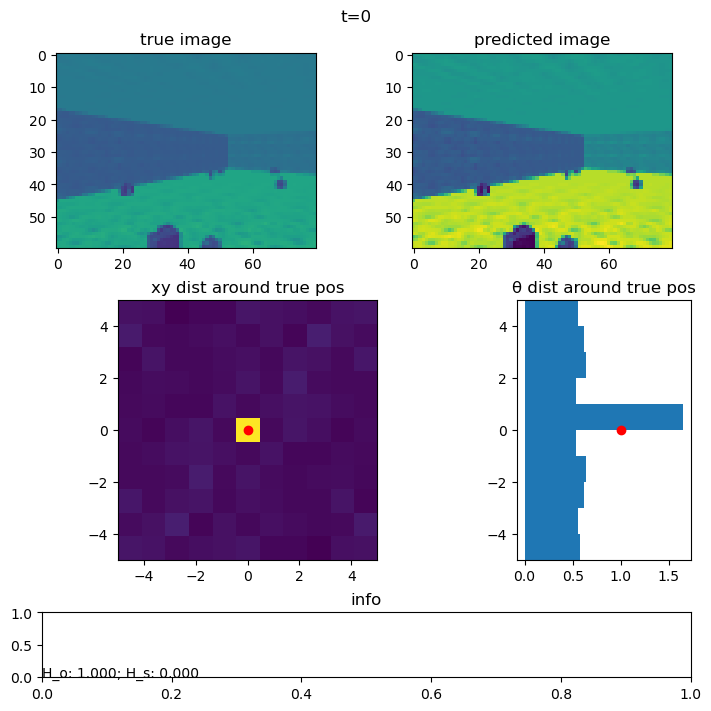

In [3]:
ani  = history[0].make_image_video()
ani.save('test.gif', progress_callback=lambda x,y: print(f"{x+1}/{y}"))